[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

(array([[-58.32561088,  16.39580098],
        [ -9.17850678, -16.8647074 ],
        [ 43.77268752, -18.98878383],
        [-45.40116727,  38.60317319],
        [  2.91140185, -58.24078851],
        [ -3.20248766, -21.52552851],
        [-22.81844087,  -3.43403155],
        [ 11.79926864, -73.15239292],
        [ 65.90917206,   9.0731767 ],
        [  5.47656058,  12.88566619],
        [  4.89948148,  -1.886511  ],
        [-26.89549573, -37.98384114],
        [-39.3128035 ,  59.04475251],
        [-24.29077996, -81.43161943],
        [-50.80185432,  49.12406273],
        [ -9.69179695,   3.0328725 ],
        [-15.35732375,   9.35559714],
        [ 68.55258917,  -6.98960174],
        [ 12.94808002, -21.53530592],
        [ 77.78632648, -39.05242333],
        [ 26.90942032, -11.60861808],
        [-61.72472251,   7.70723602],
        [ 77.04181344,  23.47209767],
        [ 32.52473737, -46.63895008],
        [ 21.00142862,   3.8627624 ],
        [ 77.33397369,   8.04047446],
        [ 12

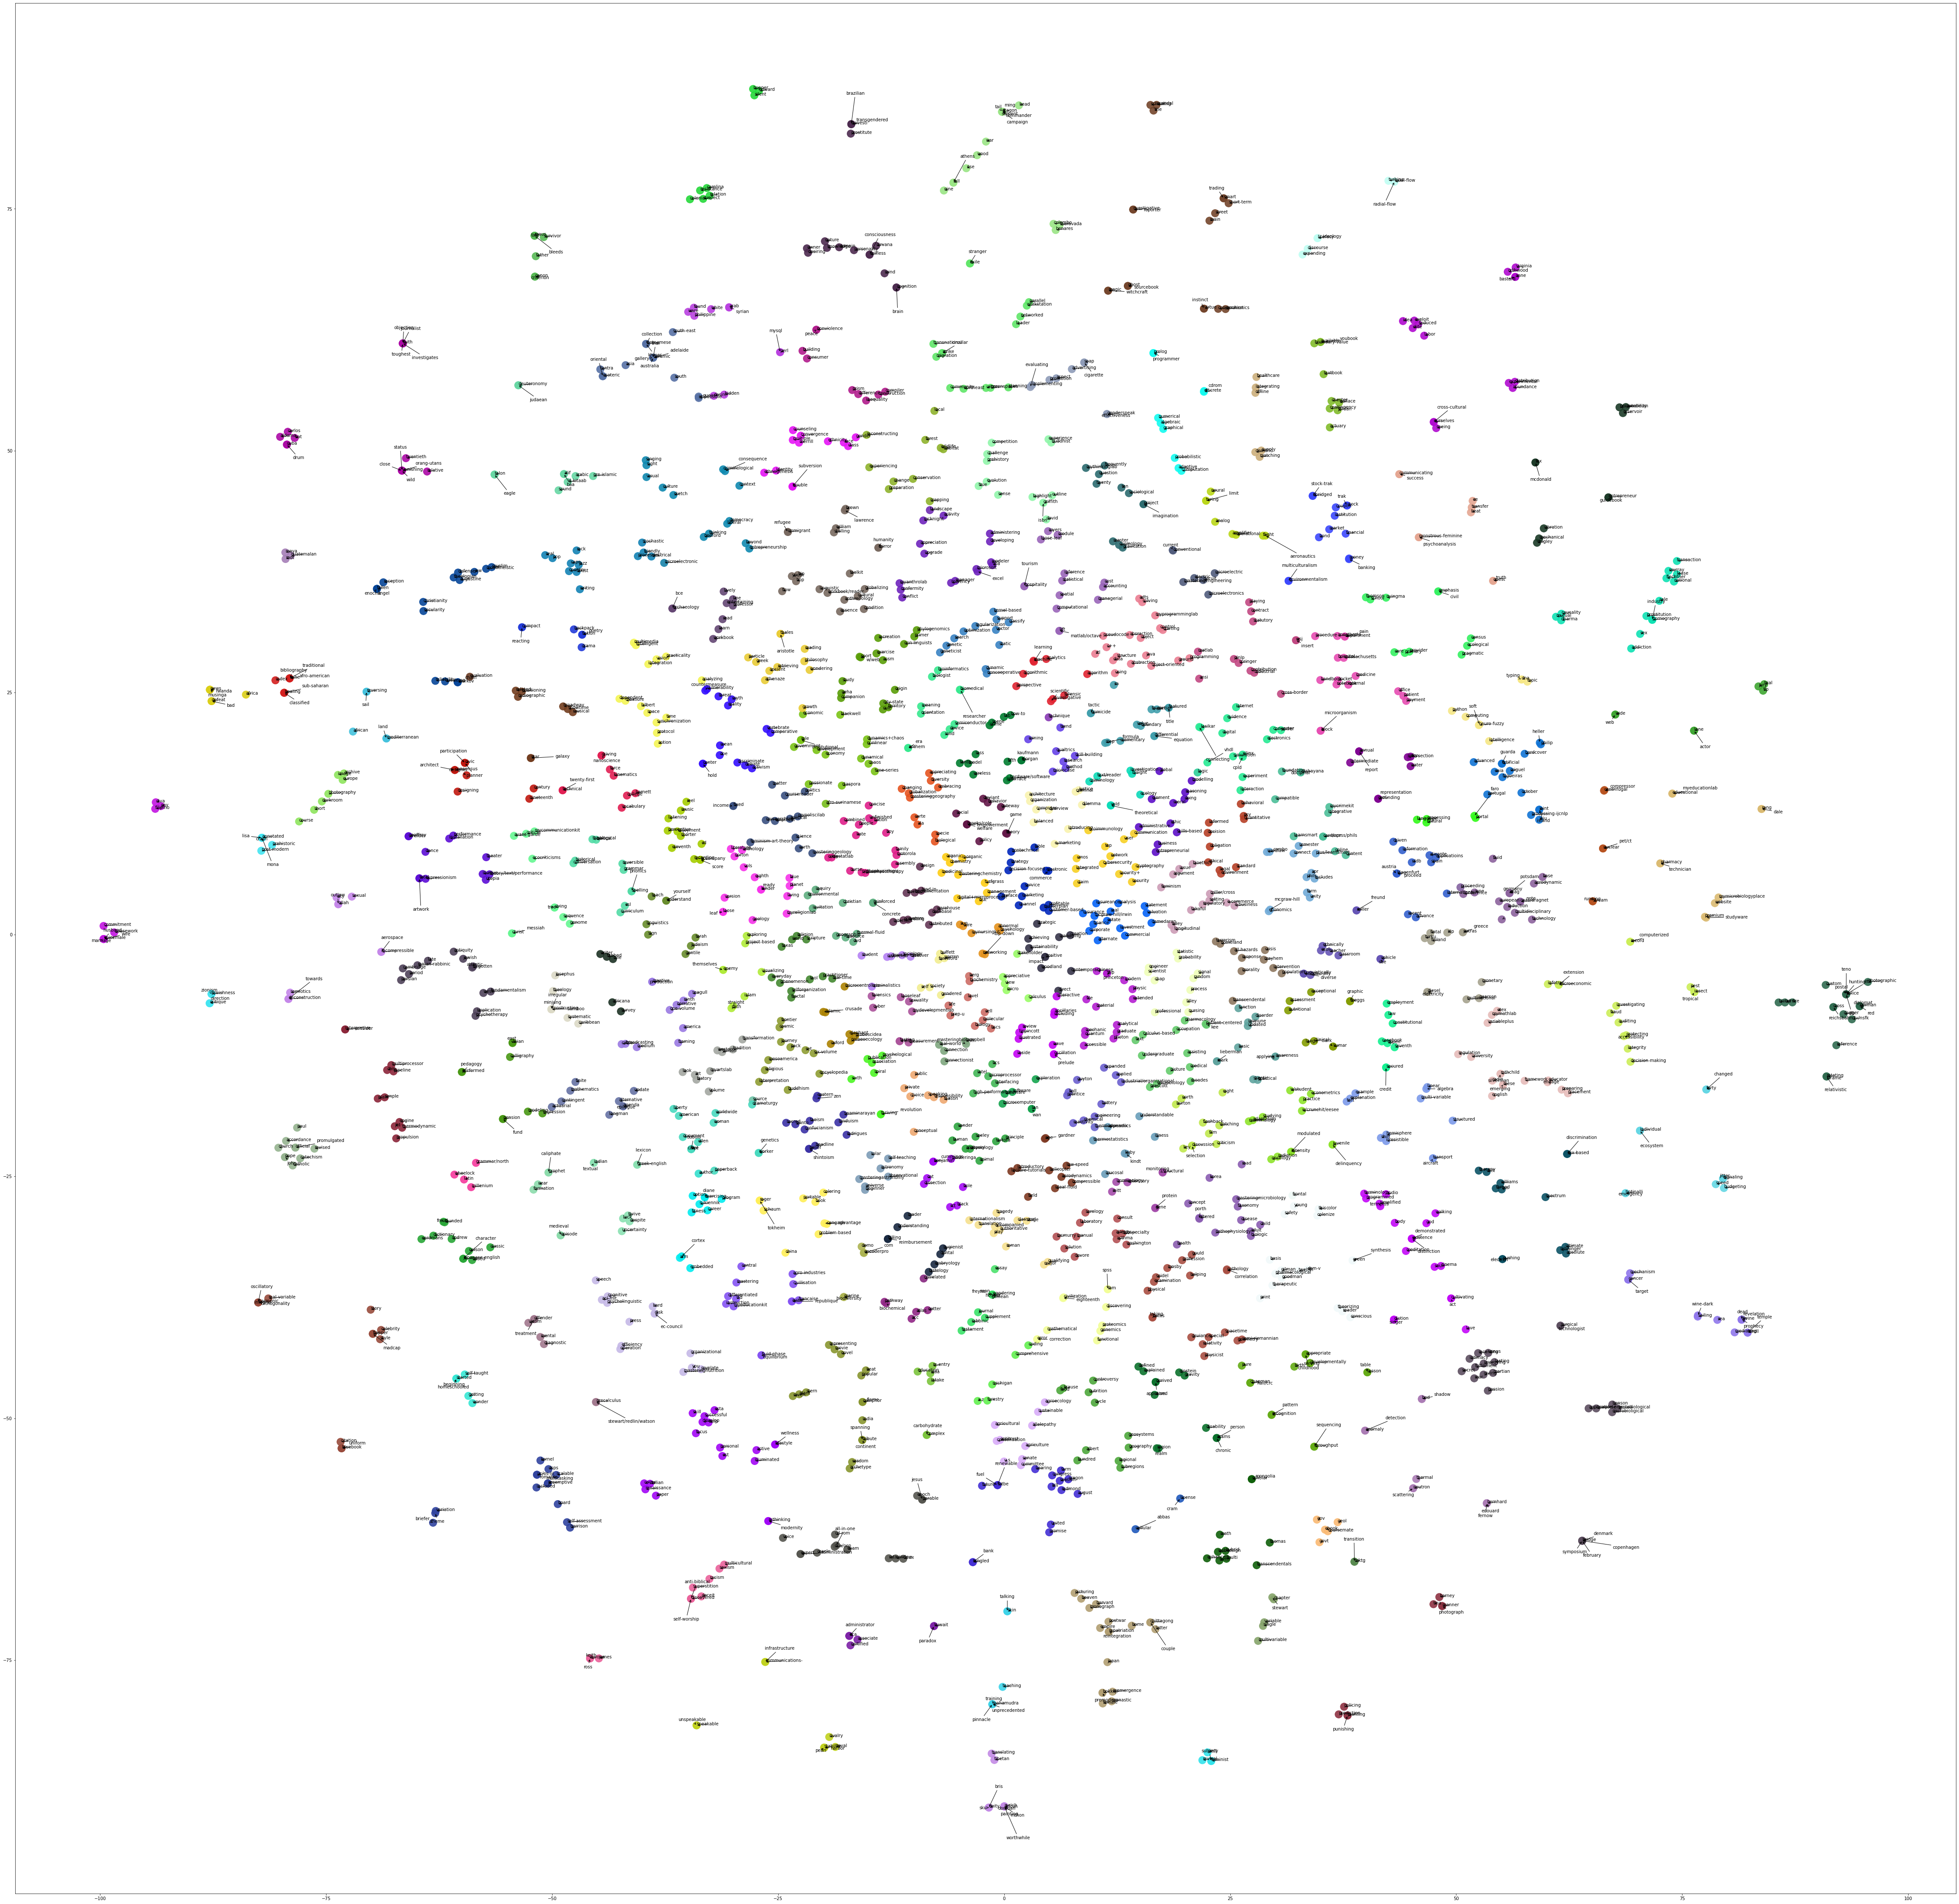

In [38]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Unsupervised Learning')
nltk.download('all')
import networkx as nx
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding as LLE
from sklearn.feature_extraction.text import TfidfTransformer

wordnet_lemmatizer = WordNetLemmatizer()
titles = [line.rstrip() for line in open('all_book_titles.txt')]
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

#adding more stopwords for this specific problem
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

def my_tokenizer(s):
    s = s.lower() #downcase
    tokens = nltk.tokenize.word_tokenize(s) #split string into words (token)
    tokens = [t for t in tokens if len(t) > 2] #remove short words, they are probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words in their base form 
    tokens = [t for t in tokens if t not in stopwords] #remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, for e.g. "3rd edition"
    return tokens

#create a word to index map so that we can create our word frequency vectors later
#lets also save the tokenized versions so we don't have to tokenize again later
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
print("Number of titles:", len(titles))
print("First title:", titles[0])

for title in titles:
    try:
        title = title.encode('ascii', 'ignore') #this will throw exception for bad characters
        title = title.decode('utf-8')
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    
    except Exception as e:
        print(e)
       
def tokens_to_vectors(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] += 1
    return x

N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D,N)) # terms will go along rows, documents along columns
i = 0

for tokens in all_tokens:
    X[:,i] = tokens_to_vectors(tokens)
    i += 1

def d(u, v):
    diff = u - v
    return diff.dot(diff)

def cost(X, R, M):
    cost = 0
    for k in range(len(M)):
        diff = X - M[k]
        sq_distances = (diff * diff).sum(axis=1)
        cost += (R[:,k] * sq_distances).sum()
    return cost

def plot_k_means(X, K, index_word_map, max_iter=20, beta=1.0, show_plots=True):
    N, D = X.shape
    M = np.zeros((K, D))
    R = np.zeros((N, K))
    exponents = np.empty((N,K))

    #initialize M (mean) to random
    for k in range(K):
        M[k] = X[np.random.choice(N)]

    costs = np.zeros(max_iter)
    for i in range(max_iter):
        #step-1: determime assignments / responsibilities
        for k in range(K):
            for n in range(N):
                exponents[n,k] = np.exp(-beta * d(M[k], X[n]))                

        R = exponents / exponents.sum(axis=1, keepdims=True)

        #step-2 : recalculate means
        for k in range(K):
            M[k] = R[:,k].dot(X) / R[:,k].sum()
        
        costs[i] = cost(X, R, M)
        if i > 0:
            if np.abs(costs[i] - costs[i-1]) < 10e-5:
                break

    if show_plots:
        random_colors = np.random.random((K, 3))
        colors = R.dot(random_colors)
        plt.figure(figsize=(80.0, 80.0))
        plt.scatter(X[:,0], X[:,1], s=300, alpha=0.9, c=colors)
        annotate1(X, index_word_map)
        #plt.show()
        plt.savefig("test.png")

    #print out the clusters
    hard_responsibilities = np.argmax(R, axis=1) # is an N-size array of cluster indentities
    #lets reverse the order so its cluster identity --> word index
    cluster2word = {}
    for i in range(len(hard_responsibilities)):
        word = index_word_map[i]
        cluster = hard_responsibilities[i]
        if cluster not in cluster2word:
            cluster2word[cluster] = []
        cluster2word[cluster].append(word)

    #print out words grouped by clusters
    for cluster, wordlist in cluster2word.items():
        print("Cluster", cluster, "-->", wordlist) 

    return M, R    

def annotate1(X, index_word_map, eps=0.1):
    N, D = X.shape
    placed = np.empty((N, D))
    for i in range(N):
        x, y = X[i]
        #if x, y is close to something already plotted move it
        close = []

        for retry in range(3):
            for j in range(i):
                diff = np.array([x,y]) - placed[j]

                #if something is close, append it to the close list
                if diff.dot(diff) < eps:
                    close.append(placed[j])

            if close:
                #then the close list is not empty
                x += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                y += (np.random.randn() + 0.5) * (1 if np.random.rand() < 0.5 else -1)
                close = [] #we will again start with an empty list
            else:
                #nothing close, lets break!
                break
        
        placed[i] = (x, y)

        plt.annotate(s=index_word_map[i], xy = (X[i,0], X[i,1]), xytext=(x,y),
            arrowprops = {'arrowstyle': '->', 'color':'black'})

print("Vocab size:" , current_index)
transformer = TfidfTransformer()
X = transformer.fit_transform(X).toarray()
reducer = TSNE()
Z = reducer.fit_transform(X)
plot_k_means(Z[:,:2], current_index//10, index_word_map, show_plots=True)